# User-level graph

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import statsmodels.api as sm
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

from utils import ROOTPATH, build_df_year, generate_index
from backbone import disparity_filter

In [2]:
df2012 = build_df_year(2012, with_text=True, with_time=False)
generate_index()

from utils import USERS, SUBREDDITS, user2index, index2user, subr2index, index2subr

building base dataframe for year 2012...
- fetching submissions for year 2012
- fetching comments for year 2012


## basic descriptives
### per-user submissions / subreddits

In [3]:
# visualize distributions 

def plot_user_subr_distribution(dfyear, year):
    user_aggr = dfyear.groupby("author").agg({"subreddit": lambda x: set(list(x))}).reset_index()
    user_aggr["n_subr"] = user_aggr["subreddit"].map(lambda x: len(x))
    plt.hist(user_aggr["n_subr"], bins=15, color="#FF4500")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("# of subreddits", fontsize=14)
    plt.ylabel("# of users", fontsize=14)
    plt.savefig(ROOTPATH + f"output/fig/user_subreddit_distribution_{year}.svg")
    return user_aggr

def plot_user_subm_distribution(dfyear, year):
    user_aggr = dfyear.groupby("author").agg({"submission_id": lambda x: set(list(x))}).reset_index()
    user_aggr["n_subm"] = user_aggr["submission_id"].map(lambda x: len(x))
    plt.hist(user_aggr["n_subm"], bins=15, color="#FF4500")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("# of submissions", fontsize=14)
    plt.ylabel("# of users", fontsize=14)
    plt.savefig(ROOTPATH + f"output/fig/user_submission_distribution_{year}.svg")
    return user_aggr

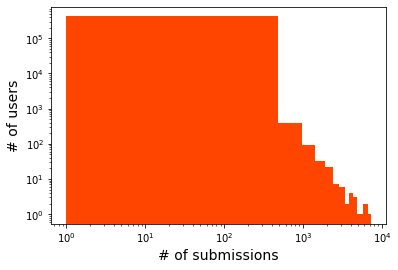

In [4]:
user_aggr_subm2012 = plot_user_subm_distribution(df2012, "2012")

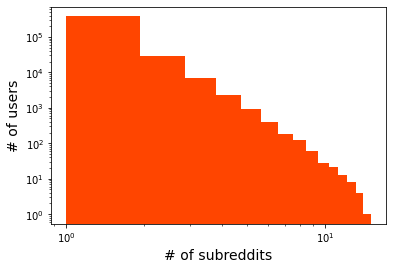

In [5]:
user_aggr_subr2012 = plot_user_subr_distribution(df2012, "2012")

## subsetting: only look at active multi-subreddit users

In [6]:
def subset(user_aggr_submyear, user_aggr_subryear, dfyear):
    ACTIVEUSERS = user_aggr_submyear[user_aggr_submyear["n_subm"]>=10].author.unique()
    MULTICOMMUSERS = user_aggr_subryear[user_aggr_subryear["n_subr"]>=2].author.unique()
    SUBSETUSERS = list(set(ACTIVEUSERS) & set(MULTICOMMUSERS))
    print("subset size:", len(SUBSETUSERS))
    dfyear_subset = dfyear[dfyear["author"].isin(SUBSETUSERS)].copy()
    return dfyear_subset

In [7]:
df2012_subset = subset(user_aggr_subm2012, user_aggr_subr2012, df2012)

subset size: 19124


## build user graph:

- node: user
- link: whether two users co-occur in a submission
    - weight: number of co-occurrences

In [8]:
def build_user_graph(dfyear_subset):
    subm_aggr = dfyear_subset.groupby("submission_id").agg({"author": lambda x: set(list(x))}).reset_index()
    subm_aggr["n_user"] = subm_aggr["author"].map(lambda x: len(x))
    subm_aggr = subm_aggr[subm_aggr["n_user"]>1].reset_index().drop(columns=["index"])  
    
    user_edges = {}
    print("recording edges...")
    # directly writing to nx.Graph() kills the kernel, ugh
    for i,row in subm_aggr.iterrows():
        users = list(row["author"])
        if i%10000==0: print(" - progress:", i/len(subm_aggr))
        userpairs = [*combinations(users,2)]
        for i,up in enumerate(userpairs):
            u1 = min(user2index[up[0]],user2index[up[1]])
            u2 = max(user2index[up[0]],user2index[up[1]])
            try:
                user_edges[(u1, u2)] += 1
            except:
                user_edges[(u1, u2)] = 1
                
    print("building graph...")       
    userg = nx.Graph()
    for p,w in user_edges.items():
        userg.add_edge(p[0], p[1], weight=w)
    
    print("graph descriptives:")
    print(" - # of nodes:", len(userg.nodes()))
    print(" - # of edges:", len(userg.edges()))
    return user_edges, userg

In [9]:
user_edges2012, userg2012 = build_user_graph(df2012_subset)

recording edges...
 - progress: 0.0
 - progress: 0.06607201850016518
 - progress: 0.13214403700033037
 - progress: 0.19821605550049554
 - progress: 0.26428807400066073
 - progress: 0.3303600925008259
 - progress: 0.39643211100099107
 - progress: 0.46250412950115627
 - progress: 0.5285761480013215
 - progress: 0.5946481665014867
 - progress: 0.6607201850016517
 - progress: 0.726792203501817
 - progress: 0.7928642220019821
 - progress: 0.8589362405021473
 - progress: 0.9250082590023125
 - progress: 0.9910802775024777
building graph...
graph descriptives:
 - # of nodes: 19055
 - # of edges: 24252795


## EDA

### distribution of degrees, weight and strength

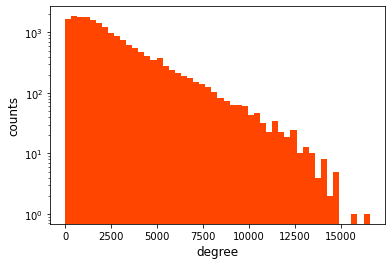

In [10]:
# degree distribution
degrees = [d for n,d in userg2012.degree()]
plt.hist(degrees, color="#FF4500", bins=50)
plt.yscale("log")
plt.xlabel("degree", fontsize=12)
plt.ylabel("counts", fontsize=12)
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/userg_degree_2012.svg")

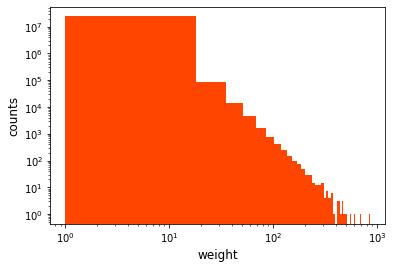

In [11]:
# weight distribution
plt.hist(list(user_edges2012.values()), color="#FF4500", bins=50)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("weight", fontsize=12)
plt.ylabel("counts", fontsize=12)
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/userg_weight_2012.svg")

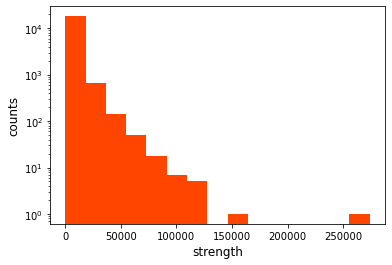

In [12]:
# strength distribution
strengths = [d for n,d in userg2012.degree(weight="weight")]
plt.hist(strengths, bins=15, color="#FF4500")
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("strength", fontsize=12)
plt.ylabel("counts", fontsize=12)
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/userg_strength_2012.svg")

In [13]:
# nx.degree_assortativity_coefficient(userg2012)  
# -0.16842736406012168
# disassortative --> degree heterogeneity

### betweenness: too many links --> need to sparsify the graph

In [14]:
# betweenness --> time complexity O(nm), n = num of nodes, m = num of links
# https://kops.uni-konstanz.de/bitstream/handle/123456789/5739/algorithm.pdf

# needs graph sparsification (fewer links)!

# betws = nx.betweenness_centrality(userg2012)
# plt.hist(betws, color="#FF4500")
# plt.yscale("log")
# # plt.xscale("log")
# plt.xlabel("betweenness", fontsize=12)
# plt.ylabel("counts", fontsize=12)
# # plt.show()
# plt.savefig(ROOTPATH + f"output/fig/userg_betweenness_2012.svg")

## toxicity at node-level

### correlations of attributes

In [15]:
# save node attributes
nodedf = pd.DataFrame()
nodedf["Id"] = [*userg2012.nodes()]
nodedf["author"] = nodedf["Id"].map(lambda x: index2user[x])
nodedf["degree"] = degrees
nodedf["strength"] = strengths
nodedf["strength_logged"] = nodedf["strength"].map(lambda x: np.log(x))
nodedf["degree_logged"] = nodedf["strength"].map(lambda x: np.log(x))

In [16]:
# get toxicity score for individual users
aggr_func = {"toxicity": lambda x: list(x)}
user_toxicity = df2012[["author","toxicity"]][df2012["toxicity"].notna()].groupby("author").agg(aggr_func).reset_index()
nodedf = nodedf.merge(user_toxicity, on="author", how="left")

In [17]:
# nodedf["toxicity"] = nodedf["toxicity"].map(lambda x: [t for t in x if ~np.isnan(t)])
nodedf["mean_tox"] = nodedf["toxicity"].map(lambda x: np.mean(x))
nodedf["max_tox"] = nodedf["toxicity"].map(lambda x: max(x) if str(x)!="nan" else np.NaN)
nodedf["min_tox"] = nodedf["toxicity"].map(lambda x: min(x) if str(x)!="nan" else np.NaN)
nodedf["range_tox"] = nodedf["toxicity"].map(lambda x: max(x)-min(x) if str(x)!="nan" else np.NaN)
nodedf["var_tox"] = nodedf["toxicity"].map(lambda x: np.var(x) if str(x)!="nan" else np.NaN)

In [18]:
# plt.scatter(nodedf["degree"], nodedf["strength"], color="#FF4500", alpha=0.02)
# plt.yscale("log")

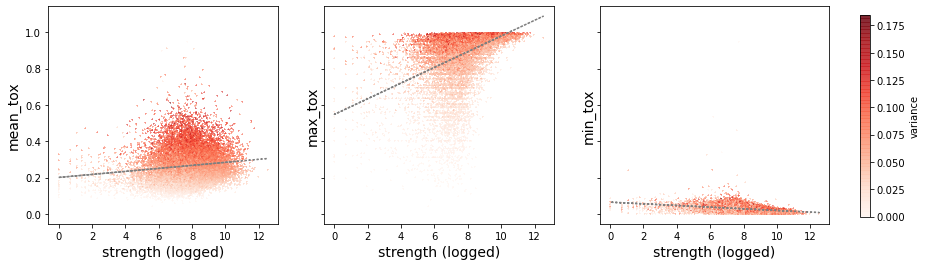

In [19]:
# plot
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True)
for i,col in enumerate(["mean_tox", "max_tox", "min_tox"]):
    x = nodedf["strength_logged"]
    y = nodedf[col]
    m,b = np.polyfit(x, y, 1)
    
    # scatterplot
    _ = ax[i].scatter(x, y, cmap="Reds", c=nodedf["var_tox"], alpha=0.6, s=1, marker="+")
    
    # OLS
    ax[i].plot(x, m*x+b, ":", color="grey")
    ax[i].set_xlabel("strength (logged)", fontsize=14)
    ax[i].set_ylabel(col, fontsize=14)
fig.colorbar(_, cax=fig.add_axes([0.93, 0.15, 0.01, 0.7]), label="variance")
# plt.show()
plt.savefig(ROOTPATH + f"output/fig/user_strength_tox2012.svg")

**OLS fitness?**

In [20]:
def OLS_fit(x,y):
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    print(results.params)
    print(print(results.summary()))

In [21]:
for col in ["mean_tox", "max_tox", "min_tox"]:
    print("\n********* OLS *********")
    print("x = strength")
    print("y =", col)
    OLS_fit(nodedf.dropna()["strength_logged"], nodedf.dropna()[col])


********* OLS *********
x = strength
y = mean_tox
const              0.200684
strength_logged    0.008317
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               mean_tox   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     325.4
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           3.80e-72
Time:                        10:33:50   Log-Likelihood:                 19140.
No. Observations:               19055   AIC:                        -3.828e+04
Df Residuals:                   19053   BIC:                        -3.826e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----

### toxicity paradox? My neighbors are on average more toxic than me?

In [22]:
TOXICITY_DICT = nodedf[["Id","mean_tox"]].set_index("Id").to_dict()["mean_tox"]

In [23]:
def examine_gfps(g):
    gfps = []
    for i,(n,v) in enumerate(TOXICITY_DICT.items()):
        if i%1000==0: print("progress:", i/len(TOXICITY_DICT))
        neighbors = g[n]
        my_tox = v
        env_tox = np.mean([TOXICITY_DICT[x] for x in neighbors])
        if my_tox > env_tox:  # I'm more toxic than my neighbors
            gfps.append(0)
        else:  # my neighbors are more toxic than me
            gfps.append(1)
    nodedf["gfp"] = gfps

In [24]:
examine_gfps(userg2012)

progress: 0.0
progress: 0.05247966413014957
progress: 0.10495932826029913
progress: 0.1574389923904487
progress: 0.20991865652059827
progress: 0.26239832065074786
progress: 0.3148779847808974
progress: 0.367357648911047
progress: 0.41983731304119654
progress: 0.47231697717134613
progress: 0.5247966413014957
progress: 0.5772763054316452
progress: 0.6297559695617948
progress: 0.6822356336919444
progress: 0.734715297822094
progress: 0.7871949619522435
progress: 0.8396746260823931
progress: 0.8921542902125427
progress: 0.9446339543426923
progress: 0.9971136184728417


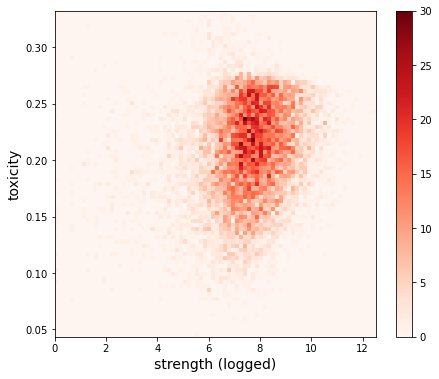

In [25]:
fig, ax = plt.subplots(figsize=(7.2,6))
x = nodedf[nodedf["gfp"]==1].dropna()["strength_logged"]
y = nodedf[nodedf["gfp"]==1].dropna()["mean_tox"]
plt.hist2d(x, y, (80,80), cmap="Reds")
plt.xlabel("strength (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
plt.colorbar()
plt.savefig(ROOTPATH + f"output/fig/fpg2012.svg")

### does these toxic users cluster together?

**Visualization Problem**: too dense!

In [28]:
def build_filter(g):
    print("building filter...")
    return disparity_filter(g)
    
def cut_edge(g, alpha):
    g2 = nx.Graph()
    print("cutting edges...")
    for i,(u,v,d) in enumerate(g.edges(data=True)):
        if i%500000==0: print("progress:", i/len(g.edges()))
        if d["alpha"] < alpha:
            g2.add_edge(u,v,weight=d["weight"])
    return g2

In [ ]:
userg2012 = build_filter(userg2012)
userg2012_small = cut_edge(userg2012, alpha=0.005)

building filter...
progress: 0.0
progress: 0.005247966413014957
progress: 0.010495932826029914
progress: 0.01574389923904487
progress: 0.020991865652059828
progress: 0.026239832065074783
progress: 0.03148779847808974
progress: 0.036735764891104694
progress: 0.041983731304119656
progress: 0.04723169771713461
progress: 0.05247966413014957
progress: 0.05772763054316452
progress: 0.06297559695617948
progress: 0.06822356336919444
progress: 0.07347152978220939
progress: 0.07871949619522435
progress: 0.08396746260823931
progress: 0.08921542902125426
progress: 0.09446339543426922
progress: 0.09971136184728417
progress: 0.10495932826029913
progress: 0.1102072946733141
progress: 0.11545526108632904
progress: 0.120703227499344
progress: 0.12595119391235896
progress: 0.13119916032537393
progress: 0.13644712673838888
progress: 0.14169509315140383
progress: 0.14694305956441878
progress: 0.15219102597743375
progress: 0.1574389923904487
progress: 0.16268695880346365
progress: 0.16793492521647863
progr

In [ ]:
def export_graph_csv(g, nodedf): 
    nodecsv = pd.DataFrame()
    nodecsv["Id"] = list(g.nodes())
    nodecsv["Label"] = nodecsv["Id"].map(lambda x: index2subr[x])
    nodecsv = nodecsv.merge(nodedf[["Id","mean_tox"]], on="Id", how="left")
    
    edgecsv = pd.DataFrame()
    sources = []
    targets = []
    weights = []
    for i,(u,v,d) in enumerate(g.edges(data=True)):
        sources.append(u)
        targets.append(v)
        weights.append(d["weight"])
    edgecsv["Source"] = sources
    edgecsv["Target"] = targets
    edgecsv["Weight"] = weights
    
    edgecsv.to_csv(ROOTPATH + "output/user_edge_2012.csv", index=False)
    nodecsv.to_csv(ROOTPATH + "output/user_node_2012.csv", index=False)
    return edgecsv, nodecsv

In [ ]:
ec, nc = export_graph_csv(userg2012_small, nodedf)